# Paintball
Go through the paintball example in chapter 9

In [9]:
import thinkbayes2
import thinkplot
import numpy as np
import math
import matplotlib.pyplot as plt

The problem is clear: there is a shooter in an unknown position in a room and we only observe his bullets hitting the wall. We want to infer his position from the observations.

The position is in 2D and we are supposing that the he is shooting towards a single wall. The (unknown) position of the shooter is expressed by $(\alpha, \beta)$, the position of the bullet is $x$ and the shooting angle is $\theta$:

<img src="paintball.png" style="width: 200px;"/>

As stated above, we observe the position of the bullet $\alpha + x$ and we want to infer the position of the shooter $(\alpha, \beta)$. As a first step we need to find a connection between the two:
$$x - \alpha = \beta \tan \theta$$

From the book:
> As a simple model, imagine that the opponent is like a rotating turret, equally likely to shoot in any direction.

This means assuming that $\theta$ has a uniform distribution. In order to check what this assumption means in terms of $x$, let's assume we know $\alpha$ and $\beta$, which then fixes the lower and upper bounds for $\theta$, assuming that the shooter only shoots towards one wall and we know the lenght of the wall ($L$).

In [25]:
L = 30
alpha = 10
beta = 15

thetaMin = - ((math.pi/2) - math.atan2(beta, alpha))
thetaMax = math.atan2((L-alpha), beta)

theta = np.random.uniform(thetaMin, thetaMax, 5000)
x = beta * np.tan(theta) + alpha

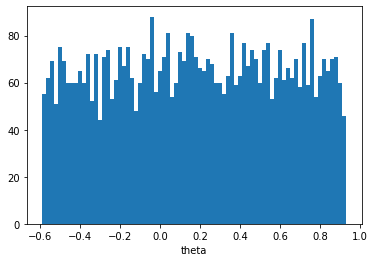

In [31]:
step = .02
bins = np.arange(thetaMin, thetaMax+step, step)

plt.figure()
plt.hist(theta, bins=bins);

plt.xlabel('theta');

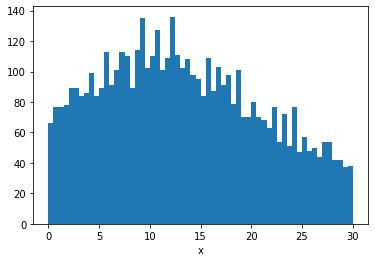

In [33]:
step = .5
bins = np.arange(x.min(), x.max()+step, step)

plt.figure()
plt.hist(x, bins=bins);

plt.xlabel('x');

The above makes sense, of course and it is the reason behind the next sentence in the book:
> In that case, he is most likely to hit the wall at location `alpha`, and less likely to hit the wall far away from `alpha`.

The explanation of this is in the variation of $x$ as $\theta$ varies, i.e. in $\frac{\textrm{d}x}{\rm{d}\theta}$:
$$\frac{\textrm{d} x}{\rm{d}\theta} = \frac{\beta}{\cos^{2}\theta}$$